In [1]:
from IPython.display import display, IFrame, Image, Markdown, SVG

In [2]:
from log_progress import log_progress
from simple_init_test import test_node

In [3]:
import difflib
import multiprocessing
import networkx as nx
import os 

from copy import deepcopy
from xml.etree import ElementTree

from comarmor.graph.utils import add_edges_from_profile, check_edges_from_profile, colors, directions
from comarmor.profile import Profile
from comarmor.transport.dds.rti.utils import get_profile_from_discovery
from comarmor.xml.utils import beautify_xml

In [4]:
def display_xml_markdown(data):
    if type(data) is str:
        display(Markdown('``` xml\n' + data + '\n```'))
    elif type(data) is ElementTree.Element:
        display(Markdown('``` xml\n' + ElementTree.tostring(data).decode('utf-8') + '\n```'))

def display_diff_markdown(a, b, fromfile, tofile, n=4, lineterm=''):
    aa = a.splitlines()
    bb = b.splitlines()
    diffs = difflib.unified_diff(a=aa, b=bb, fromfile=fromfile, tofile=tofile, n=n, lineterm=lineterm)
    diff = '\n'.join(diffs)
    display(Markdown('``` diff\n' + diff + '\n```'))

In [5]:
def plot_graph_figure(G, file_name, view='png'):
    A = nx.nx_agraph.to_agraph(G)
    A.add_subgraph()
    if view is 'pdf':
        A.draw(file_name + '.' + 'pdf', prog='dot')
        display(IFrame(file_name + '.' + view, width=950, height=300))
    elif view is 'png':
        A.draw(file_name + '.' + 'png', prog='dot')
        A.draw(file_name + '.' + 'pdf', prog='dot')
        display(Image(file_name + '.' + view))
    elif view is 'svg':
        A.draw(file_name + '.' + 'svg', prog='dot')
        display(SVG(file_name + '.' + view))
    else:
        raise ValueError("No view option: {}".format(view))

In [6]:
talker_listener_xml = "talker_listener_discovery_data.xml"
discovery =  ElementTree.parse(talker_listener_xml)
# display_xml_markdown(discovery.getroot())

In [7]:
profile_element = get_profile_from_discovery(discovery)
profile_tree = ElementTree.ElementTree(profile_element)
profile = Profile(tree=profile_tree)

talker_profile = profile.filter_profile('/talker').tree.getroot()
display_xml_markdown(beautify_xml(talker_profile))

``` xml
<?xml version="1.0" encoding="utf-8"?>
<profiles>
    <profile name="/talker">
        <attachment>/talker</attachment>
        <ros_topic qualifier="ALLOW">
            <attachment>/chatter</attachment>
            <permissions>
                <ros_publish/>
            </permissions>
        </ros_topic>
        <ros_topic qualifier="ALLOW">
            <attachment>/parameter_events</attachment>
            <permissions>
                <ros_publish/>
                <ros_subscribe/>
            </permissions>
        </ros_topic>
        <ros_topic qualifier="ALLOW">
            <attachment>/clock</attachment>
            <permissions>
                <ros_subscribe/>
            </permissions>
        </ros_topic>
        <ros_service qualifier="ALLOW">
            <attachment>/talker/set_parameters</attachment>
            <permissions>
                <ros_call/>
            </permissions>
        </ros_service>
        <ros_service qualifier="ALLOW">
            <attachment>/talker/get_parameters</attachment>
            <permissions>
                <ros_call/>
            </permissions>
        </ros_service>
        <ros_service qualifier="ALLOW">
            <attachment>/talker/get_parameter_types</attachment>
            <permissions>
                <ros_call/>
            </permissions>
        </ros_service>
        <ros_service qualifier="ALLOW">
            <attachment>/talker/list_parameters</attachment>
            <permissions>
                <ros_call/>
            </permissions>
        </ros_service>
        <ros_service qualifier="ALLOW">
            <attachment>/talker/describe_parameters</attachment>
            <permissions>
                <ros_call/>
            </permissions>
        </ros_service>
    </profile>
</profiles>

```

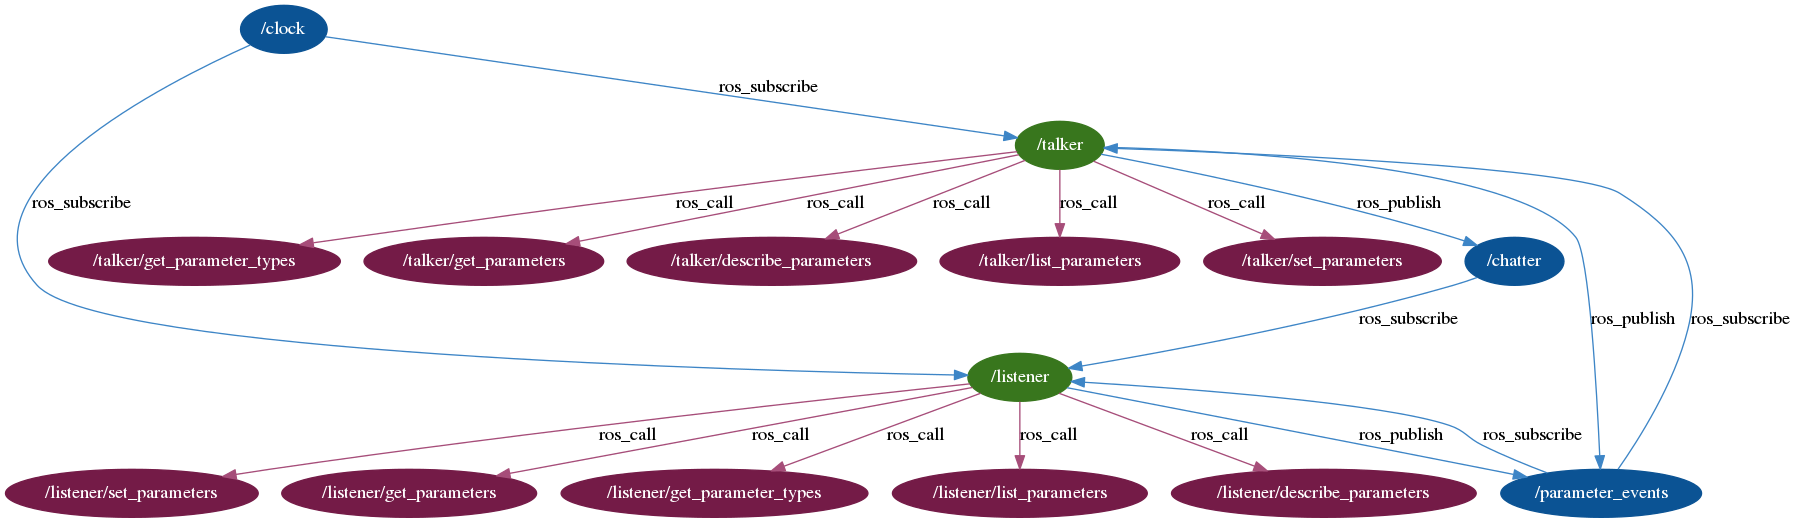

In [8]:
G_s = nx.MultiDiGraph()
add_edges_from_profile(profile, G_s)
plot_graph_figure(G_s, 'figs/G_s')

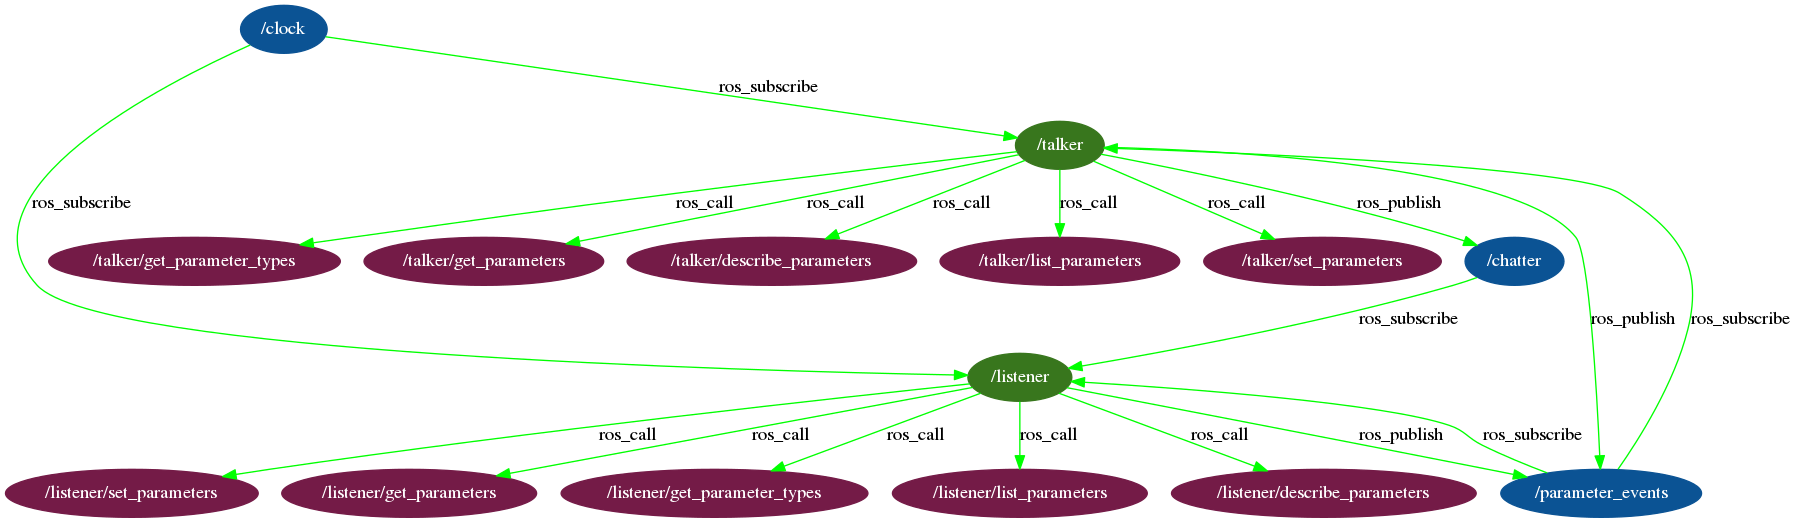

In [9]:
# L_s = G_s.copy()
L_s = G_s # use original graph to plot similar A-graph layout
check_edges_from_profile(profile, L_s)
plot_graph_figure(L_s, 'figs/L_s')

In [10]:
permission_from_object_kind_lookup = {
    'topic': ['publish', 'subscribe'],
    'ros_topic': ['ros_publish', 'ros_subscribe'],
    'ros_service': ['ros_call', 'ros_execute'],
}

def complete_edges_from_pair(G, subject_vertex, object_vertex):
    subject_, subject_values = subject_vertex
    object_, object_values = object_vertex
    permissions = permission_from_object_kind_lookup[object_values['kind']]
    for permission in permissions:
        u, v = directions[permission](subject_, object_)
        if not G.has_edge(u, v):
            G.add_edge(u, v, label=permission, color=colors[permission])

def complete_edges_from_graph(G):
    subjects = [(n, v) for n, v in G.nodes(data=True) if v['type'] == 'subject']
    objects =  [(n, v) for n, v in G.nodes(data=True) if v['type'] != 'subject']
    for subject_vertex in subjects:
        for object_vertex in objects:
            complete_edges_from_pair(G, subject_vertex, object_vertex)

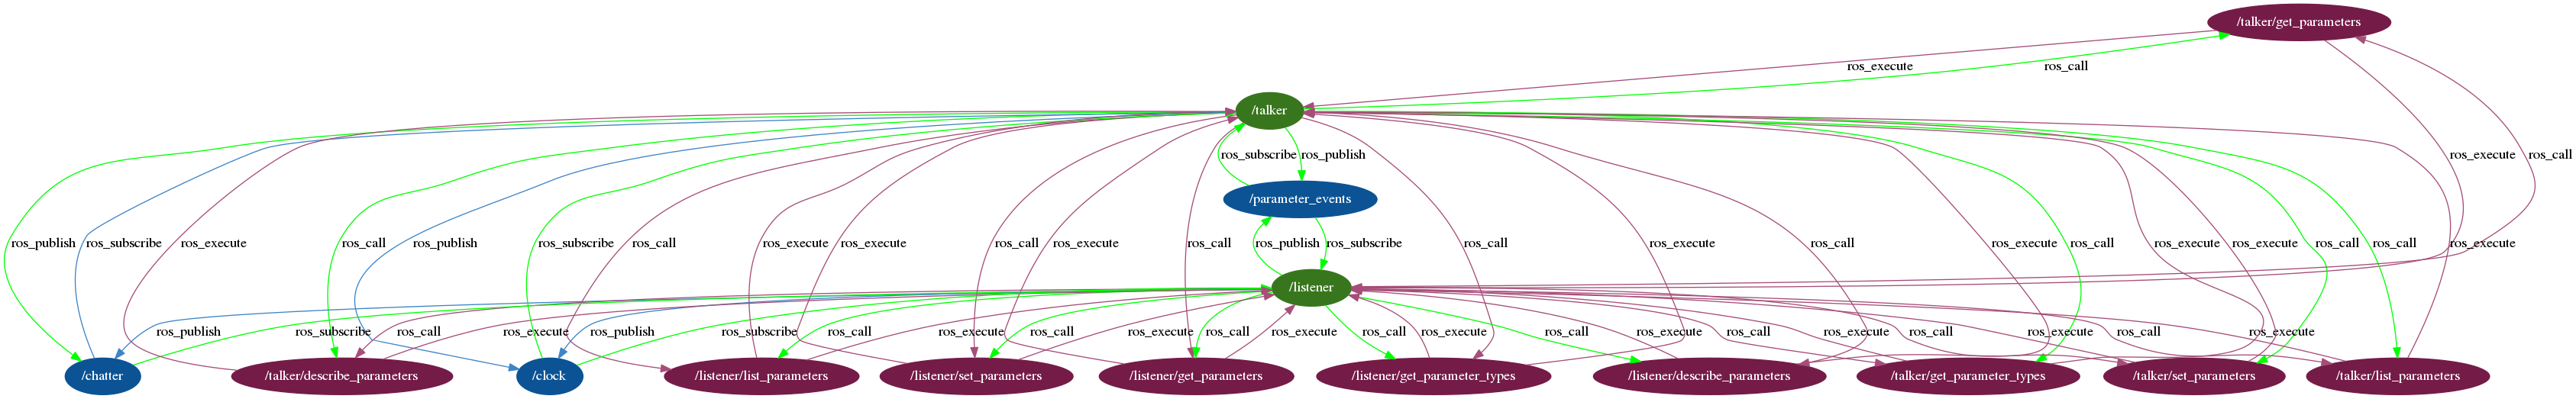

In [11]:
G_fc = G_s.copy()
complete_edges_from_graph(G_fc)
plot_graph_figure(G_fc, 'figs/G_fc')

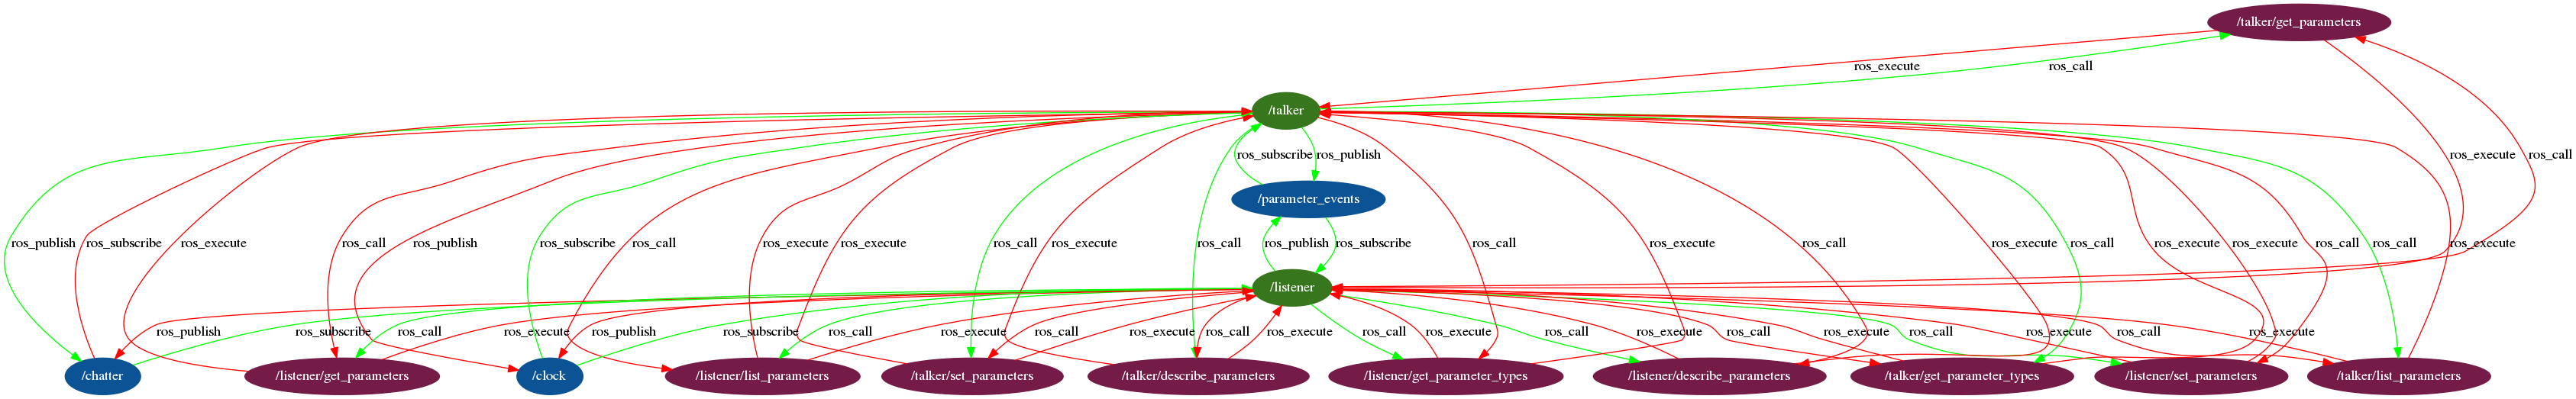

In [12]:
L_fc = G_fc.copy()
check_edges_from_profile(profile, L_fc)
plot_graph_figure(L_fc, 'figs/L_fc')

In [13]:
%%bash
mkdir -p keymint_ws
cd keymint_ws
keymint keystore init --bootstrap keymint_ros
tree .


Utilizing profile 'default_keymint_ros2_comarmor' with context:
--------------------------------------------------------------------------------
private_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/private
profile_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/profile
 public_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/public
--------------------------------------------------------------------------------
+++ Initializing 'default_keymint_ros2_comarmor'
++++ Building Authorities
+++++ Building 'ca'
++++ Installing Authorities
+++++ Installing 'ca'
.
├── private
│   ├── ca.csr.pem
│   └── ca.key.pem
├── profile
│   ├── authorities.xml
│   ├── comarmor.d
│   │   └── example.xml
│   ├── keymint_profile.xml
│   ├── package.defaults
│   │   ├── governance.xml
│   │   ├── identities.xml
│   │   └── permissions.xml
│   ├── policies.xml
│   └── profile.defaults
│       └── authorities.xml
└── public
    └── ca.cert.pem

6 directories, 11 files


In [14]:
profile_path = 'keymint_ws/profile/comarmor.d/example.xml'
with open(profile_path, 'w') as f:
    f.write(beautify_xml(profile.tree.getroot()))

In [15]:
%%bash
cd keymint_ws
keymint keystore create_pkg talker
keymint keystore create_pkg listener
tree .


Utilizing profile 'default_keymint_ros2_comarmor' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/src/talker
private_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/private
profile_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/profile
 public_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/public
--------------------------------------------------------------------------------
+++ Creating 'default_keymint_ros2_comarmor'
++++ Creating 'permissions.xml'
++++ Creating 'governance.xml'
++++ Creating 'identities.xml'
++++ Creating 'keymint_package.xml'

Utilizing profile 'default_keymint_ros2_comarmor' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/src/listener
private_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/private
profile_space => /home/ru

In [16]:
%%bash
cd keymint_ws
keymint keystore build_pkg src/talker --skip-install
keymint keystore build_pkg src/listener --skip-install
tree .


Process package 'talker' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/src/talker
  build_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/build/talker
install_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/install/talker
 public_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/public
private_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/private
--------------------------------------------------------------------------------
+++ Building 'talker'
++++ Building 'permissions.xml'
++++ Building 'governance.xml'
++++ Building '['key.pem', 'csr.pem']'

Process package 'listener' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/src/listener
  build_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/build/listener
install_space => /home/ruffsl/git/r

In [17]:
dds_action_types = ['publish', 'subscribe']
core_services = [
    'get_parameters',
    'get_parameter_types',
    'list_parameters',
    'describe_parameters',
    'set_parameters',
]
service_postfixs = ['Request', 'Reply']
core_services_with_postfixs = [i+j for i in core_services for j in service_postfixs]


def patch_permissions_for_ros2_ardent(tree):
    for dds_action_type in dds_action_types:
        actions = tree.findall('permissions/grant/allow_rule/' + dds_action_type)
        for action in actions:
            topic = action.findtext('topics/topic')
            if topic in core_services_with_postfixs:
                empty_partition = ElementTree.Element('partition')
                empty_partition.text = ''
                partitions = action.find('partitions')
                partitions.append(empty_partition)
    return tree

In [18]:
permissions_path = 'keymint_ws/build/talker/permissions.xml'
permissions = ElementTree.parse(permissions_path)
patched_permissions = patch_permissions_for_ros2_ardent(deepcopy(permissions))

In [19]:
permissions_str = beautify_xml(permissions.getroot())
patched_permissions_str = beautify_xml(patched_permissions.getroot())

with open(permissions_path, 'w') as f:
    f.write(patched_permissions_str)

display_diff_markdown(a=permissions_str,
                      b=patched_permissions_str,
                      fromfile='permissions',
                      tofile='patched_permissions')

``` diff
--- permissions
+++ patched_permissions
@@ -48,80 +48,90 @@
                         <topic>set_parametersRequest</topic>
                     </topics>
                     <partitions>
                         <partition>rq/talker</partition>
+                        <partition/>
                     </partitions>
                 </publish>
                 <subscribe>
                     <topics>
                         <topic>set_parametersReply</topic>
                     </topics>
                     <partitions>
                         <partition>rr/talker</partition>
+                        <partition/>
                     </partitions>
                 </subscribe>
                 <publish>
                     <topics>
                         <topic>get_parametersRequest</topic>
                     </topics>
                     <partitions>
                         <partition>rq/talker</partition>
+                        <partition/>
                     </partitions>
                 </publish>
                 <subscribe>
                     <topics>
                         <topic>get_parametersReply</topic>
                     </topics>
                     <partitions>
                         <partition>rr/talker</partition>
+                        <partition/>
                     </partitions>
                 </subscribe>
                 <publish>
                     <topics>
                         <topic>get_parameter_typesRequest</topic>
                     </topics>
                     <partitions>
                         <partition>rq/talker</partition>
+                        <partition/>
                     </partitions>
                 </publish>
                 <subscribe>
                     <topics>
                         <topic>get_parameter_typesReply</topic>
                     </topics>
                     <partitions>
                         <partition>rr/talker</partition>
+                        <partition/>
                     </partitions>
                 </subscribe>
                 <publish>
                     <topics>
                         <topic>list_parametersRequest</topic>
                     </topics>
                     <partitions>
                         <partition>rq/talker</partition>
+                        <partition/>
                     </partitions>
                 </publish>
                 <subscribe>
                     <topics>
                         <topic>list_parametersReply</topic>
                     </topics>
                     <partitions>
                         <partition>rr/talker</partition>
+                        <partition/>
                     </partitions>
                 </subscribe>
                 <publish>
                     <topics>
                         <topic>describe_parametersRequest</topic>
                     </topics>
                     <partitions>
                         <partition>rq/talker</partition>
+                        <partition/>
                     </partitions>
                 </publish>
                 <subscribe>
                     <topics>
                         <topic>describe_parametersReply</topic>
                     </topics>
                     <partitions>
                         <partition>rr/talker</partition>
+                        <partition/>
                     </partitions>
                 </subscribe>
             </allow_rule>
             <default>DENY</default>
```

In [20]:
%%bash
cd keymint_ws
keymint keystore build_pkg src/talker --skip-build
keymint keystore build_pkg src/listener --skip-build
tree .


Process package 'talker' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/src/talker
  build_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/build/talker
install_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/install/talker
 public_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/public
private_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/private
--------------------------------------------------------------------------------
+++ Installing 'talker'
++++ Installing 'permissions.p7s'
++++ Installing 'governance.p7s'
++++ Installing '['key.pem', 'cert.pem']'

Process package 'listener' with context:
--------------------------------------------------------------------------------
 source_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/src/listener
  build_space => /home/ruffsl/git/ruffsl/PPAC_ROS2/keymint_ws/build/listener
install_space => /home/ruf

In [21]:
%%bash
cd keymint_ws
cp public/ca.cert.pem install/talker
cp public/ca.cert.pem install/listener

In [22]:
cwd = os.getcwd()
os.environ["ROS_SECURITY_ROOT_DIRECTORY"] = os.path.join(cwd, 'keymint_ws', 'install')
os.environ["ROS_SECURITY_ENABLE"] = "true"
os.environ["ROS_SECURITY_STRATEGY"] = "Enforce"

In [23]:
L_tp = G_fc.copy()
unit_cases = []
for u, v, a in L_tp.edges(data=True):
    subject_name = u if L_tp.node[u]['type'] == 'subject' else v
    object_name  = u if L_tp.node[u]['type'] != 'subject' else v
    unit_case = {
        'test' : {
            'subject_name': subject_name,
            'object_kind': L_tp.node[object_name]['kind'],
            'permission': a['label'],
            'object_name': object_name,},
        'edge': {
            'u': u,
            'v': v,
        }       
    }
    unit_cases.append(unit_case)

In [24]:
def test_case(unit_case):
    qualifier = test_node(**unit_case['test'])
    unit_case['test']['qualifier'] = qualifier
    unit_case['test']['color'] = colors[qualifier]
    unit_case['edge']['qualifier'] = qualifier
    unit_case['edge']['color'] = colors[qualifier]
    return unit_case['edge']

In [25]:
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 2   # arbitrary default
pool = multiprocessing.Pool(processes=cpus)
results = pool.map(test_case, unit_cases)

In [26]:
for result in results:
    L_tp[result['u']][result['v']][0]['color'] = result['color']
    L_tp[result['u']][result['v']][0]['qualifier'] = result['qualifier']

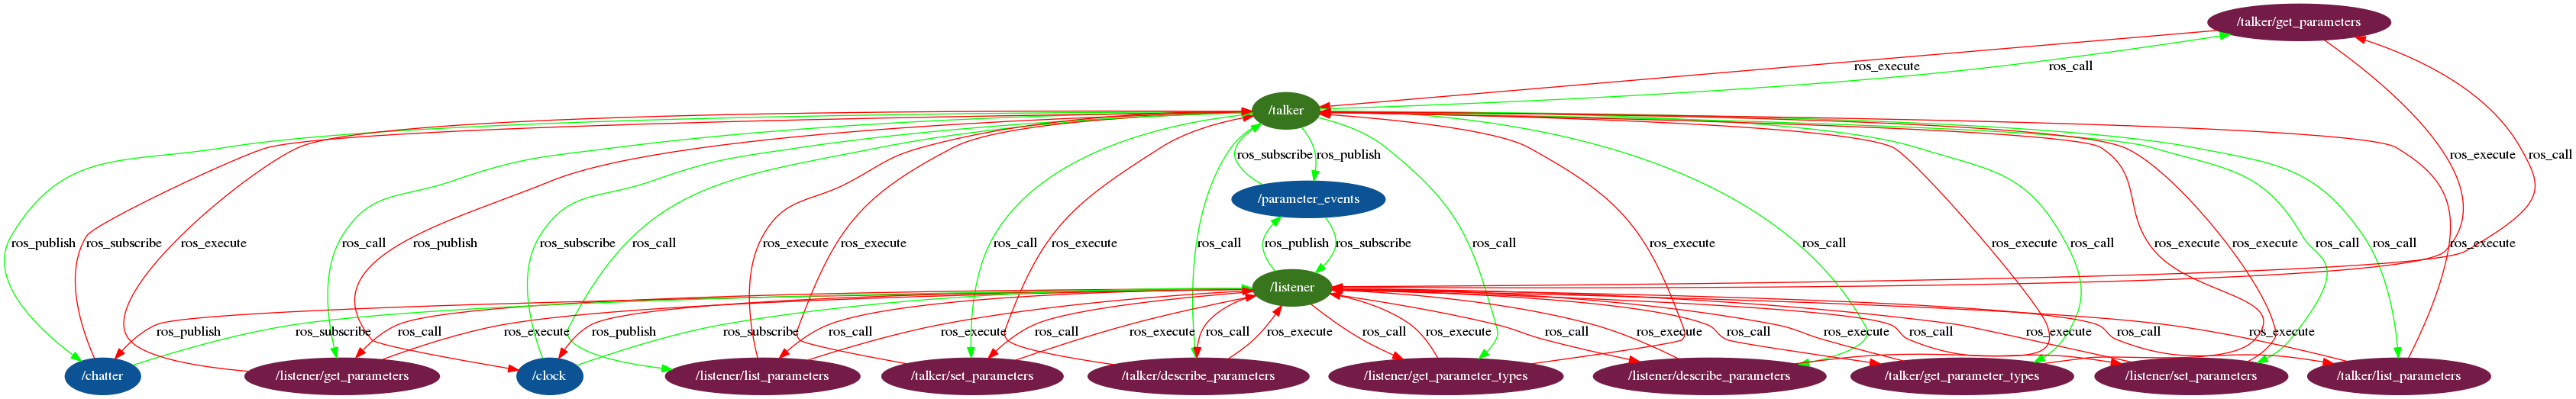

In [27]:
plot_graph_figure(L_tp, 'figs/L_tp')

In [28]:
L_tp_edges = L_tp.edges(keys=True)
G_s_edges = G_s.edges(keys=True)

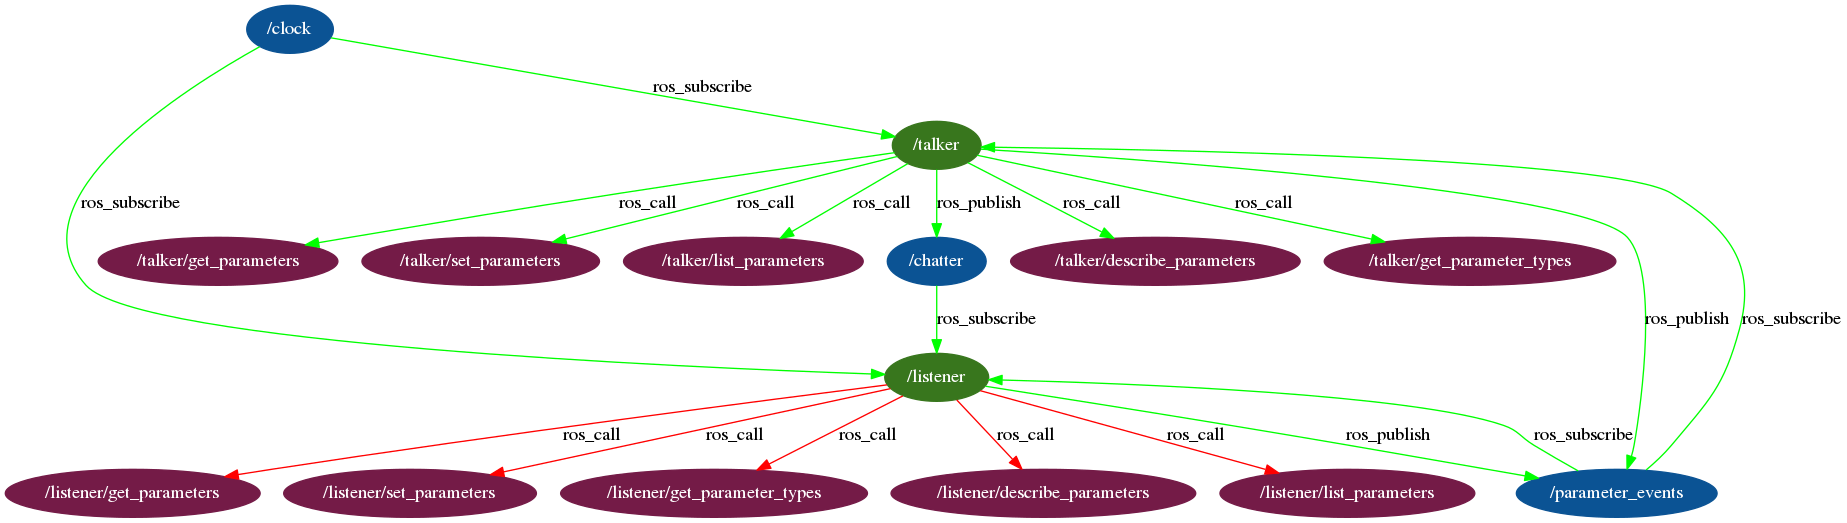

In [29]:
intersec_of_G_s_in_L_tp = L_tp.copy()
for edge in L_tp_edges:
    if edge not in G_s_edges:
        intersec_of_G_s_in_L_tp.remove_edge(*edge)

plot_graph_figure(intersec_of_G_s_in_L_tp, 'figs/intersec_of_G_s_in_L_tp')

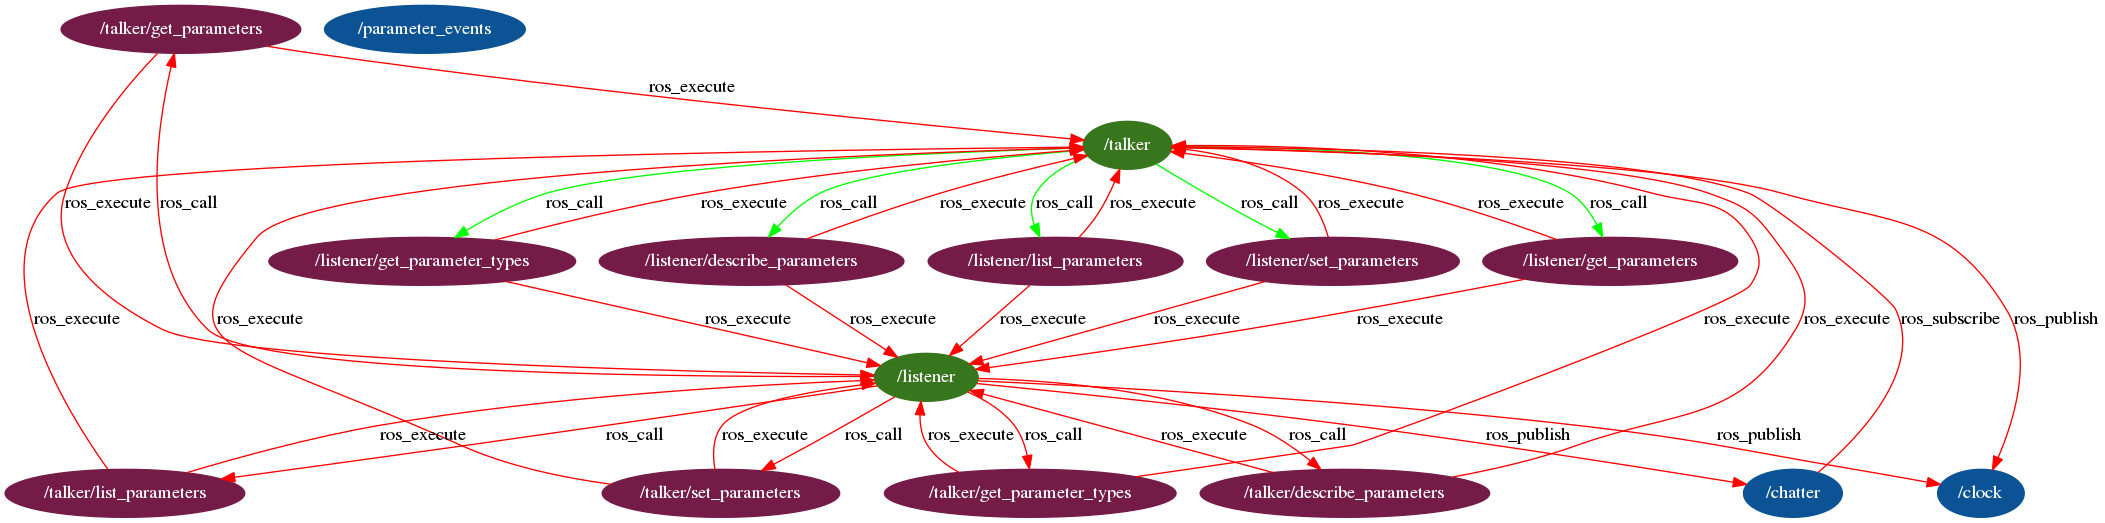

In [30]:
rc_of_G_s_in_L_tp = L_tp.copy()
for edge in L_tp_edges:
    if edge in G_s_edges:
        rc_of_G_s_in_L_tp.remove_edge(*edge)

plot_graph_figure(rc_of_G_s_in_L_tp, 'figs/rc_of_G_s_in_L_tp')